# Data analyse

Eerst eens kijken of er een onderlinge samenhang te vinden is. Seaborn heeft hiervoor een mooie plot in de aanbieding: pairplot. In deze plot wordt iedere parameter tenopzichte van alle parameters geplot. Op de diagonaal staat de verdeling van de parameter zelf.

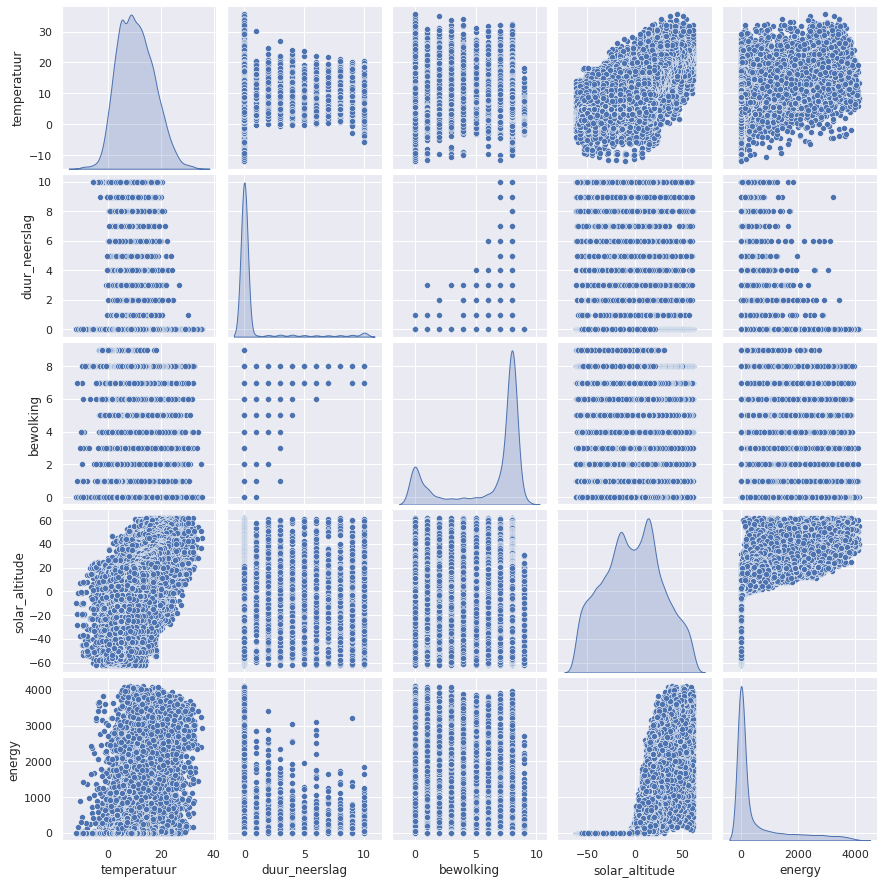

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns

# Database inlezen
conn = sqlite3.connect("dataset.db")
data = pd.read_sql('SELECT * FROM history', conn)
#data.set_index("Time", inplace=True)

sns.set_theme()
sns.pairplot(data, diag_kind="kde")

data.dropna(axis=0, inplace=True)

Een overduidelijk lineair verband is hier niet te vinden. Om te kijken of we de opbrengst kunnen gaan voorspellen worden er twee machine learn modellen gebruikt: kNN en ...(CNN)?

Als eerste wordt kNN gebruikt. <uitleg over kNN toevoegen>

/tmp/ipykernel_7210/3221643263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_energy.drop(columns=["duur_neerslag"], inplace=True)


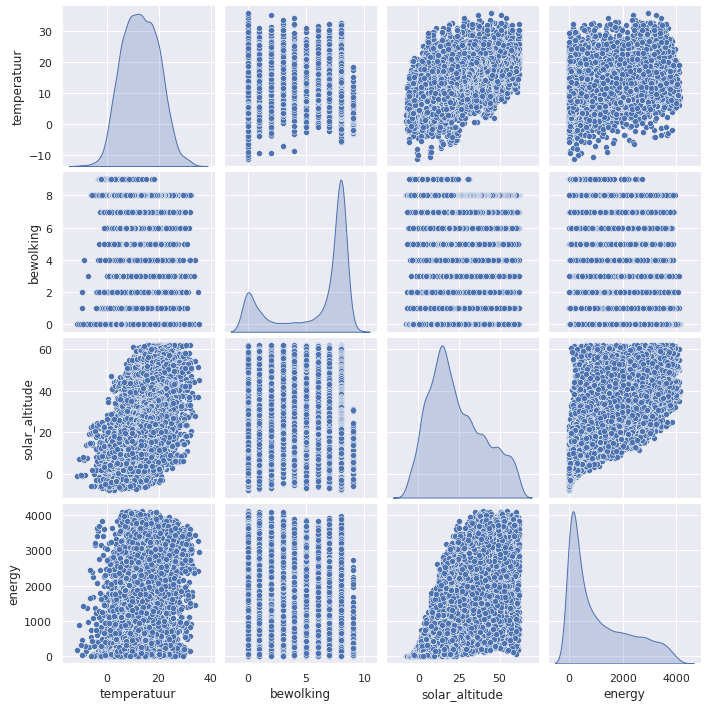

In [8]:
data_energy = data[data["energy"] > 0]
data_energy.drop(columns=["duur_neerslag"], inplace=True)
sns.pairplot(data_energy, diag_kind="kde");

In [36]:
# Modules importeren
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

# Opsplitsen dataset
X = data[["temperatuur", "duur_neerslag", "bewolking", "solar_altitude", "solar_azimuth"]]
y = data[["energy"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# kNN model opstarten, met k=5
knn_model = KNeighborsRegressor(n_neighbors=5)

# Data fitten aan model
knn_model.fit(X_train, y_train)

# Voorspelling berekenen, matchen aan train set
train_preds = knn_model.predict(X_train)
score = knn_model.score(X_train, y_train)
print(f'Score train set: {score}')

# Matchen aan test set
score = knn_model.score(X_test, y_test)
print(f'Score test set: {score}')

# Afwijking t.o.v. model uitrekenen
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
print(f'RMSE: {rmse}')

Score train set: 0.8934159245593037
Score test set: 0.8292931968788024
RMSE: 314.45437969832153


In [6]:
data_energy

,Time,temperatuur,duur_neerslag,bewolking,solar_altitude,solar_azimuth,energy
9,2019-09-16 10:00:00+00:00,17.7,0,8.0,37.110053,b'\x93P\xe4\x03`\xebb@',836.0
10,2019-09-16 11:00:00+00:00,19.1,0,8.0,40.212850,b'\x8e$\xfb\xa4\xc1Ee@',1008.0
11,2019-09-16 12:00:00+00:00,19.1,0,8.0,40.210177,b'8\xfa\t~H\xbbg@',662.0
12,2019-09-16 13:00:00+00:00,19.0,0,8.0,37.102550,b'\x00^np\x94\x15j@',222.0
13,2019-09-16 14:00:00+00:00,16.4,4,8.0,31.430602,"b',=&\x10\x190l@'",108.0
...,...,...,...,...,...,...,...
20963,2022-02-02 12:00:00+00:00,9.6,0,8.0,21.518096,b'*\xa3~Y\xa0\xd3f@',1640.0
20964,2022-02-02 13:00:00+00:00,9.9,0,8.0,19.849152,b'\xd5\x81\x86\x7f_\xbah@',1574.0
20965,2022-02-02 14:00:00+00:00,9.8,0,7.0,15.867273,b'\x97\x8b\x93\xe0!\x89j@',200.0
20966,2022-02-02 15:00:00+00:00,9.8,0,8.0,9.956286,"b'""P\xe0h\xae5l@'",130.0


In [41]:
# Bepalen welke parameters beste zijn voor de voorspelling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
scaled_X_train = X_train #scaler.fit_transform(X_train)
scaled_X_test = X_test #scaler.fit_transform(X_test)

# Welke parameters te optimaliseren
parameters = { 
    "n_neighbors": range(1, 50),
    "weights": ["uniform", "distance"]
}

# Zoeken naar beste parameters (duurt ff)
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(scaled_X_train, y_train)
best_params = gridsearch.best_params_

print(f'Best parameters: {best_params}')

# Herhalen kNN model:
# kNN model opstarten, met k=14 (uitkomst gridsearch)
knn_model = KNeighborsRegressor(n_neighbors=9, weights="distance")

# Data fitten aan model
knn_model.fit(scaled_X_train, y_train)

# Voorspelling berekenen, matchen aan train set
train_preds = knn_model.predict(scaled_X_train)
score = knn_model.score(scaled_X_train, y_train)
print(f'Score train set: {score}')

# Afwijking t.o.v. model uitrekenen
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
print(f'RMSE tov train set: {rmse}')

# Voorspelling berekenen, matchen aan test set
test_preds = knn_model.predict(scaled_X_test)
score = knn_model.score(scaled_X_test, y_test)
print(f'Score test set: {score}')

# Afwijking t.o.v. model uitrekenen
mse = mean_squared_error(y_test, test_preds)
rmse = sqrt(mse)
print(f'RMSE tov test set: {rmse}')

Best parameters: {'n_neighbors': 9, 'weights': 'distance'}
Score train set: 1.0
RMSE tov train set: 0.0
Score test set: 0.8357619005113189
RMSE tov test set: 388.7244813961855


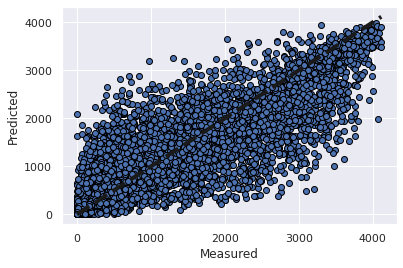

In [42]:
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

predicted = cross_val_predict(knn_model, scaled_X_train, y_train)

fig, ax = plt.subplots()
ax.scatter(y_train, predicted, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
plt.show()

In [1]:
# Neural network beter?
from sklearn.neural_network import MLPRegressor

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.fit_transform(X_test)

regr = MLPRegressor(random_state=1, max_iter=500, warm_start=True).fit(scaled_X_train, y_train)

regr.score(scaled_X_train, y_train)
regr.score(scaled_X_test, y_test)

NameError: name 'StandardScaler' is not defined